<a id='home'></a>
### purpose

Answer Question 2 of manuscript: How is offset performance affected by how the training data is constructed (i.e., the experimental set of loci and environments and populations used)?

### outline

1. [load data](#data)
1. [Q2A - Is method performance driven by causal loci or by genome-wide patterns of Isolation By Environment?](#q2a)

In [1]:
from pythonimports import *
from myfigs import slope_graph, adjust_box_widths, save_pdf, scatter2d, histo_box

import MVP_summary_functions as mvp

import itertools as it
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene  # brown-forsythe test of equal variance
plt.rcParams.update({'font.family' : 'serif'})

t0 = dt.now()  # notebook timer

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set'
figdir = makedir(op.join(summarydir, 'figs'))
# pkldir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/all_performance_dicts'

mvp.latest_commit()
session_info.show()

#########################################################
Today:	November 15, 2023 - 09:48:31 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit 947b68b2130080c7648ce4eb039c4dffacfd57d4  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Nov 14 11:48:51 2023 -0500
#########################################################



<a id='data'></a>
# 1. load data

[top](#home)

In [2]:
# get all_scores data
all_scores = mvp.combine_level_dicts(
    use_bcs_data=False,
    keep_nuisance=False,
#     repdirs = ['/work/lotterhos/MVP-Offsets/run_20220919_0-225']
)

filtering criteria:
	use_bcs_data = False
	performance = garden_performance
	num_traits = None
	ntraits = None
	marker_set = None
	remove_structcrxn = False
	keep_nuisance = False
	remove_rda_outliers = True


reading reps: 100%|███████████████| 10/10 [00:24<00:00,  2.46s/it]


0-225
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


225-450
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


450-675
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


675-900
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


900-1125
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1125-1350
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1350-1575
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1575-1800
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1800-2025
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


2025-2250
	 RONA num seeds =  225
	 lfmm2 num seeds =  22

In [3]:
# combine program dataframes into one df
all_program_data = mvp.combine_program_data(all_scores)

all_program_data.head(1)

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,program,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal,cor_FPR_temp_neutSNPs,cor_FPR_sal_neutSNPs,plevel_pleio,demography,ntraits,noncausal_env,structcrxn
1231094,1,-0.847677,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-center-to-edge,m-constant,all,1231094,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,temp_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,RONA-temp_opt,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.500854,0.46129,NaN,0.521256,0.0,1-trait_no pleiotropy,N-cline-center-to-edge_m-constant,NaN,NaN,NaN


In [4]:
programs = all_program_data.program.unique().tolist()

programs

['RONA-temp_opt',
 'RONA-sal_opt',
 'lfmm2',
 'GF',
 'rda-nocorr',
 'rda-structcorr']

In [5]:
# how many validation scores per seed (= num gardens)
for program in programs:
    df = all_program_data[all_program_data.program == program].copy()
    print(program, df.index.value_counts().unique())  # counts of unique seeds (seeds are indices)
    
# rona has 100 common gardens * 3 marker sets
# other programs have this ^ with the added permutation of 1-trait sims with 2-envs

RONA-temp_opt [300]
RONA-sal_opt [300]
lfmm2 [300]
GF [300]
rda-nocorr [300]
rda-structcorr [300]


<a id='q2a'></a>
# Q2A

Is method performance driven by causal loci or by genome-wide patterns of Isolation By Environment?

[top](#home)

In [6]:
def cleanup_fig(g, xlabel="Landscape", loc='center left', bbox_to_anchor=None, color_by=None, fontsize=11,
                ncol=1, replace=None, figsize=(8, 4), one_trait=False, title=None):
    """Make the fig look rull pretty."""
    
    g.figure.set_size_inches(figsize)
    
    adjust_box_widths(list(g.axes[0]), 0.85)
    
    g.set(ylim=(0.65, -1),
          yticks=mvp.ytick_labels,
          yticklabels=mvp.ytick_labels)
    
    if title is not None:
        g.set(title=title)
    
#     g.set_axis_labels(xlabel, "Performance (Kendall's $\\tau$)", fontsize=12)
    g.ax.set_xlabel(xlabel, fontsize=12)
    g.ax.set_ylabel("Performance (Kendall's $\\tau$)", fontsize=12)

    mvp.jitter_fliers(g)
    
    # line at tau = 0
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=1, zorder=0)

    mvp.add_legend(g.figure, color_by=color_by, loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize,
                   ncol=ncol, one_trait=one_trait
                  )
    
    g.tight_layout()
    
    mvp.update_ticklabels(g.axes.flat[0], replace=replace)
    
    pass
        

### marker set by program

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/marker_set_by_program_performance_box_2-trait.pdf


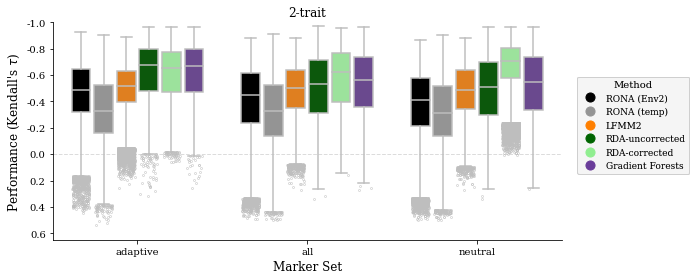

In [7]:
# 2-trait fig
g = sns.catplot(data=mvp.subset_dataframe(all_program_data,
                                          num_traits=2,
                                          keep_nuisance=False),
                x='marker_set',
                y='score',
                hue='program',
                order=mvp.hue_order['marker_set'],
                hue_order=mvp.hue_order['program'],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='Marker Set', color_by='program', bbox_to_anchor=(1, 0.55), fontsize=9, title='2-trait')


save_pdf(op.join(figdir, 'marker_set_by_program_performance_box_2-trait.pdf'))

plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/marker_set_by_program_performance_box_1-trait.pdf


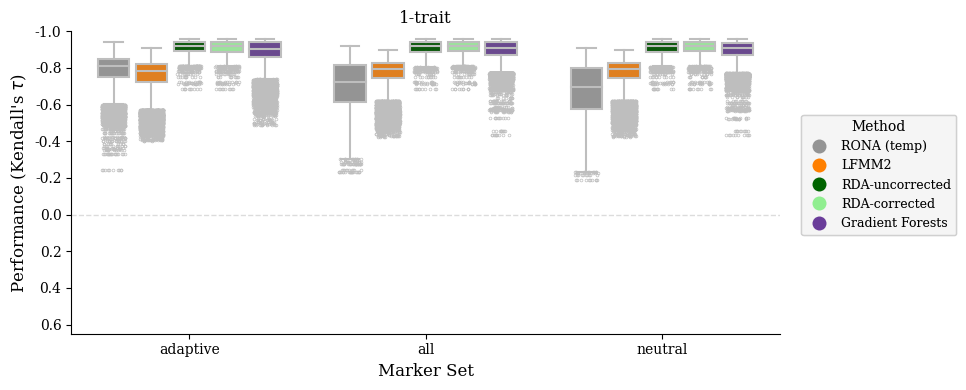

In [8]:
# 1-trait fig
data = mvp.get_1trait_data(all_program_data)

g = sns.catplot(data=data,
                x='marker_set',
                y='score',
                hue='program',
                order=mvp.hue_order['marker_set'],
                hue_order=mvp.hue_order['program'][1:],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='Marker Set', color_by='program', fontsize=9, bbox_to_anchor=(1, 0.55), one_trait=True,
            title='1-trait')

save_pdf(op.join(figdir, 'marker_set_by_program_performance_box_1-trait.pdf'))

plt.show()

#### program by marker set

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/program_set_by_marker_set_performance_box_2-trait.pdf


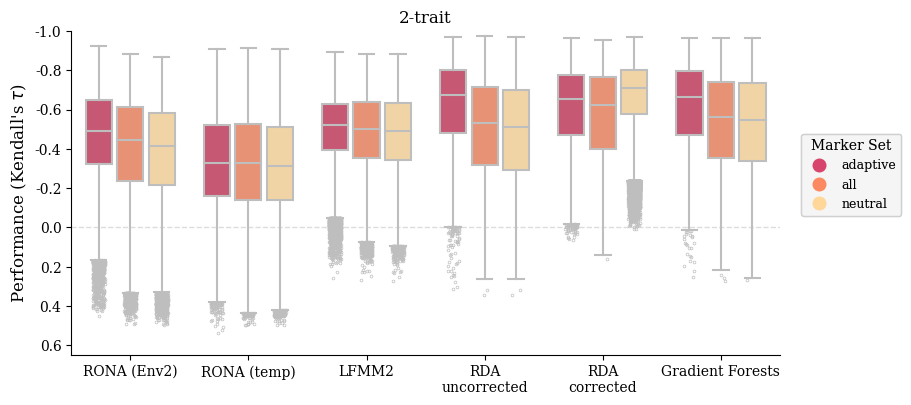

In [9]:
# 2-trait fig
g = sns.catplot(data=mvp.subset_dataframe(all_program_data,
                                          num_traits=2,
                                          keep_nuisance=False),
                x='program',
                y='score',
                hue='marker_set',
                hue_order=mvp.hue_order['marker_set'],
                order=mvp.hue_order['program'],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel=None, color_by='marker_set', bbox_to_anchor=(1, 0.55), fontsize=9,
            replace=('-', '\n'), title='2-trait')
    
save_pdf(op.join(figdir, 'program_set_by_marker_set_performance_box_2-trait.pdf'))

plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/program_set_by_marker_set_performance_box_1-trait.pdf


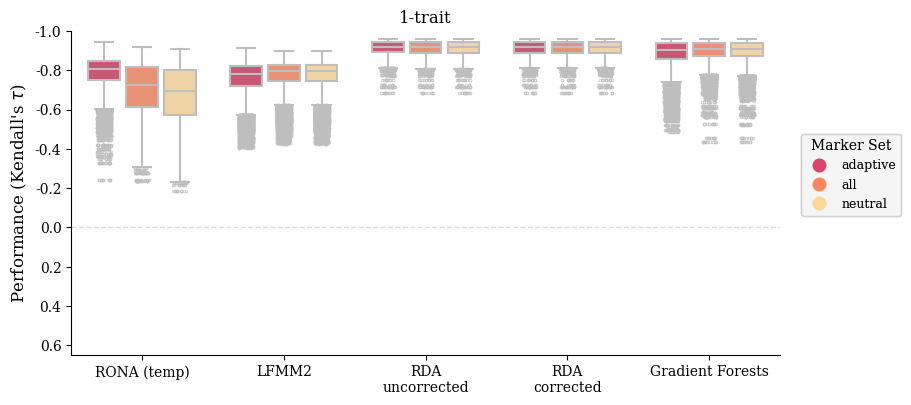

In [10]:
# 1-trait fig
data = mvp.get_1trait_data(all_program_data)

g = sns.catplot(data=data,
                x='program',
                y='score',
                hue='marker_set',
                hue_order=mvp.hue_order['marker_set'],
                order=mvp.hue_order['program'][1:],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel=None, color_by='marker_set', bbox_to_anchor=(1, 0.55), fontsize=9,
            replace=('-', '\n'), title='1-trait'
           )
    
save_pdf(op.join(figdir, 'program_set_by_marker_set_performance_box_1-trait.pdf'))

plt.show()

### other vars


In [11]:
keys(mvp.hue_order)

['landscape',
 'glevel',
 'pleio',
 'slevel',
 'popsize',
 'migration',
 'noncausal_env',
 'marker_set',
 'program',
 'demography']

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/landscape_set_by_marker_set_performance_box_1-trait.pdf


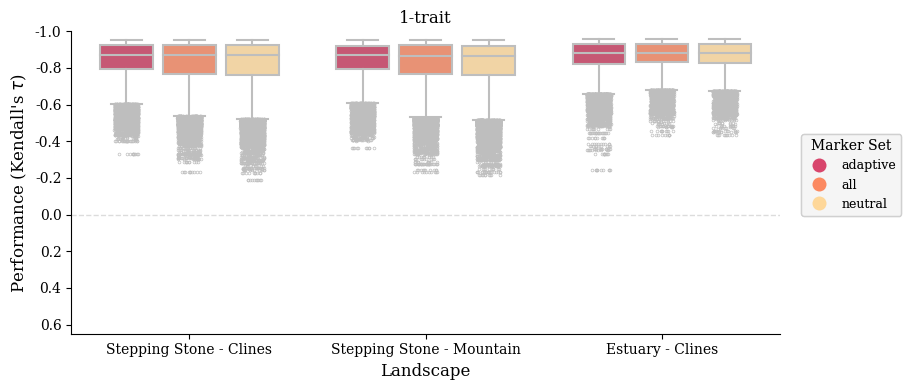

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/glevel_set_by_marker_set_performance_box_1-trait.pdf


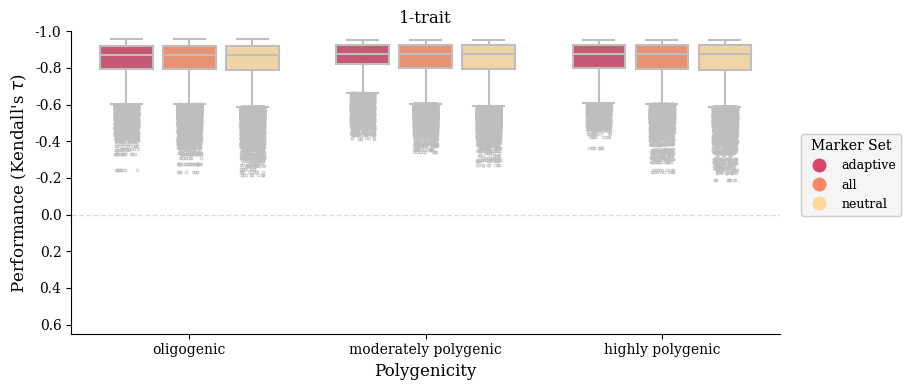

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/popsize_set_by_marker_set_performance_box_1-trait.pdf


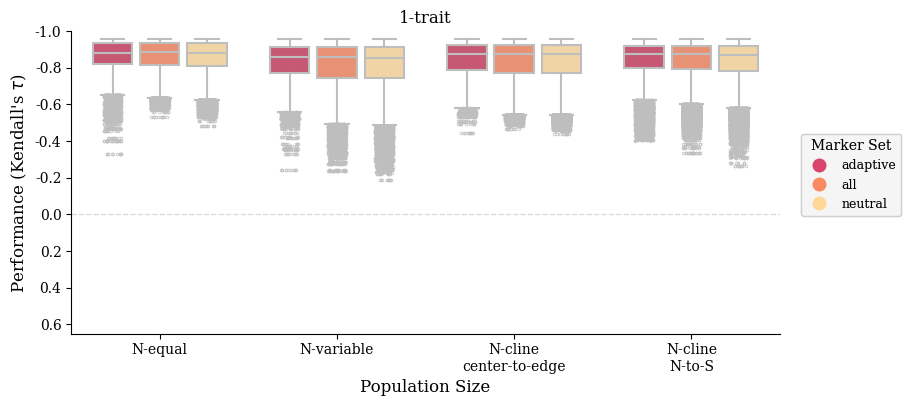

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/migration_set_by_marker_set_performance_box_1-trait.pdf


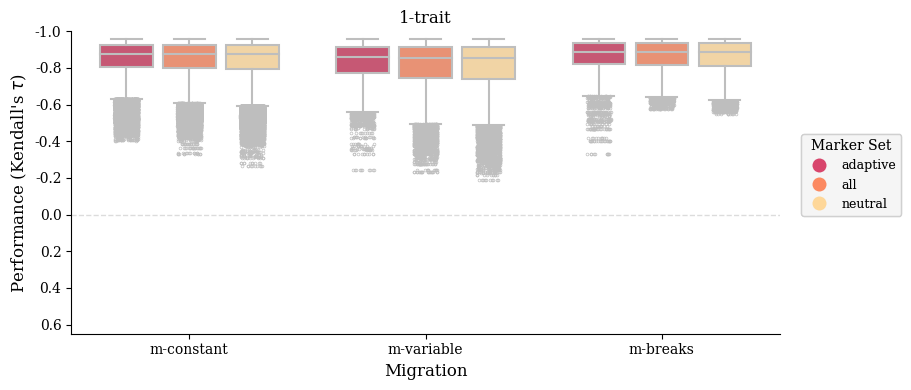

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/demography_set_by_marker_set_performance_box_1-trait.pdf


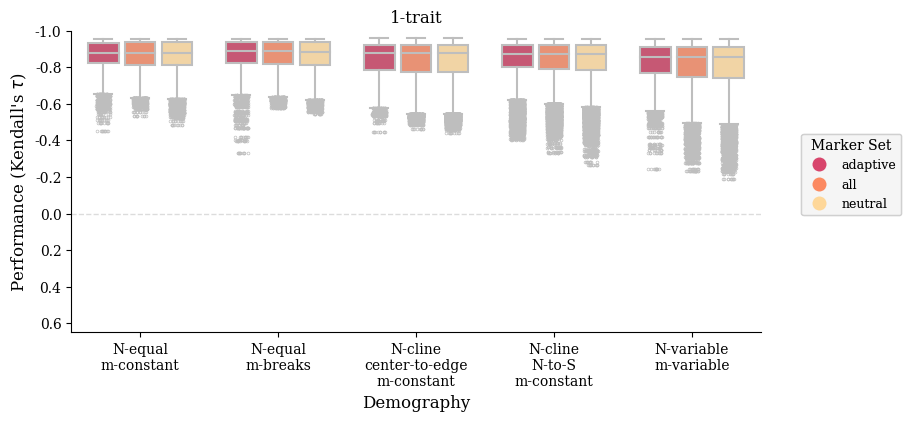

In [12]:
# 1-trait
data = mvp.get_1trait_data(all_program_data)

for x, x_order in mvp.hue_order.items():
    if x in ['program', 'noncausal_env', 'pleio', 'slevel', 'marker_set']:
        continue
    
    g = sns.catplot(data=data,
                    x=x,
                    y='score',
                    hue='marker_set',
                    hue_order=mvp.hue_order['marker_set'],
                    order=x_order,
                    kind='box',
                    legend=False,
                    **mvp.boxplot_kwargs
                   )

    cleanup_fig(g, xlabel=mvp.factor_names[x], color_by='marker_set', bbox_to_anchor=(1, 0.55), fontsize=9,
                replace=('cline-', 'cline\n'), title='1-trait'
               )
    
    if x == 'demography':
        g.axes.flat[0].set_xticklabels(
            [label.get_text().replace(' m', '\nm') for label in g.axes.flat[0].get_xticklabels()]
        )

    save_pdf(op.join(figdir, f'{x}_set_by_marker_set_performance_box_1-trait.pdf'))

    plt.show()
    

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/landscape_set_by_marker_set_performance_box_2-trait.pdf


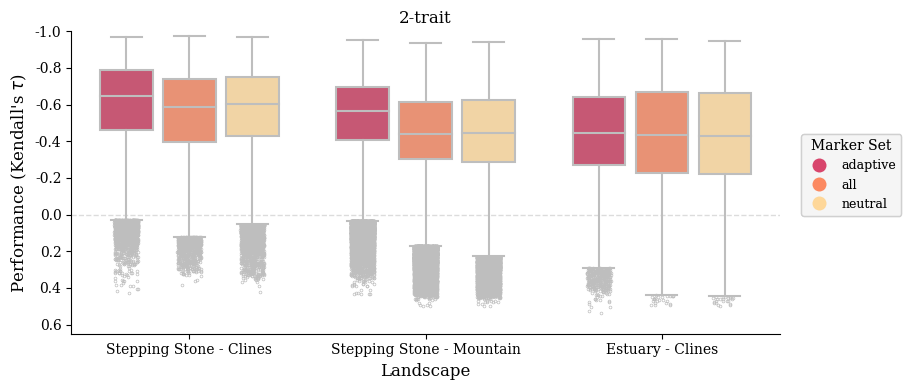

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/glevel_set_by_marker_set_performance_box_2-trait.pdf


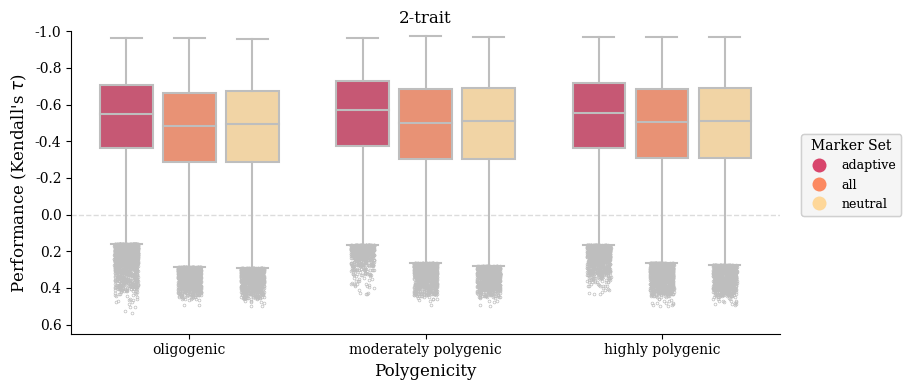

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/pleio_set_by_marker_set_performance_box_2-trait.pdf


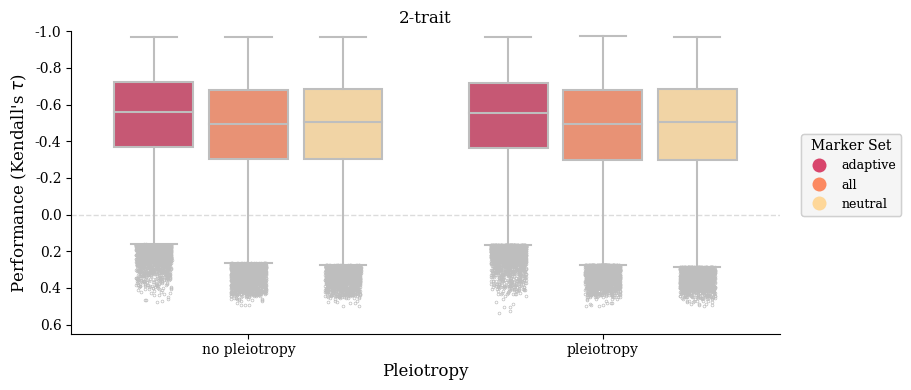

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/slevel_set_by_marker_set_performance_box_2-trait.pdf


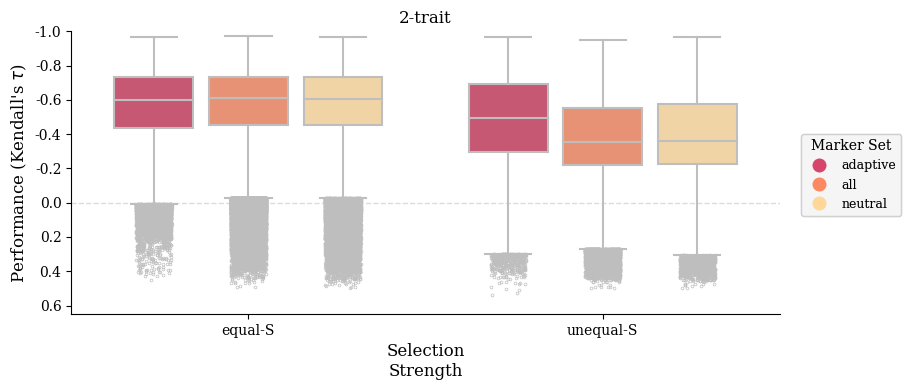

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/popsize_set_by_marker_set_performance_box_2-trait.pdf


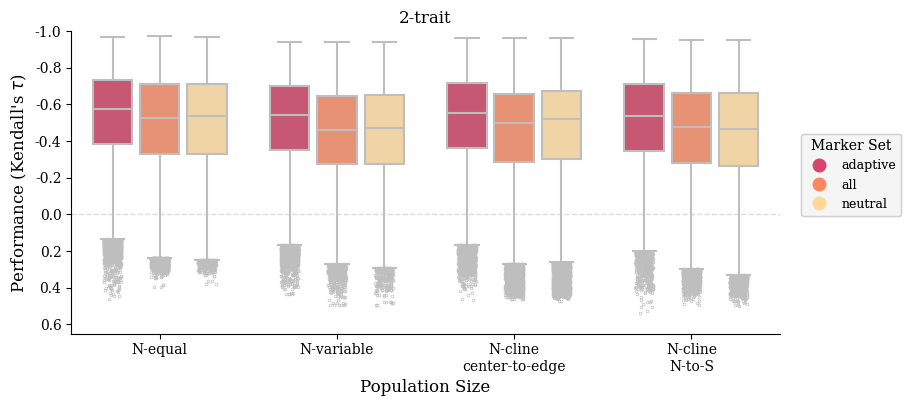

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/migration_set_by_marker_set_performance_box_2-trait.pdf


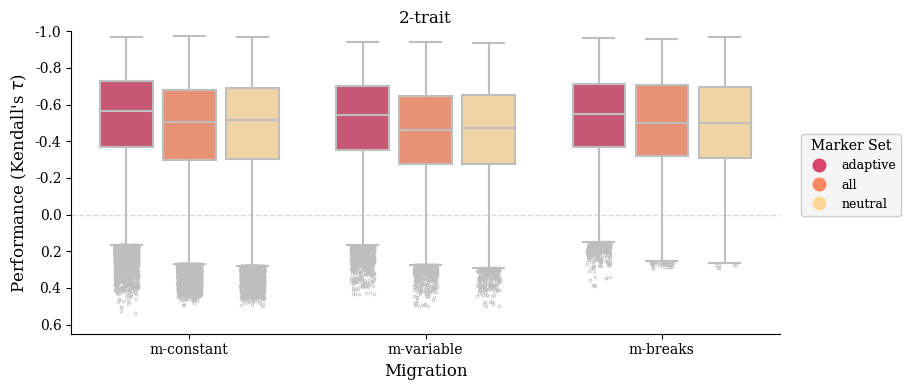

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/demography_set_by_marker_set_performance_box_2-trait.pdf


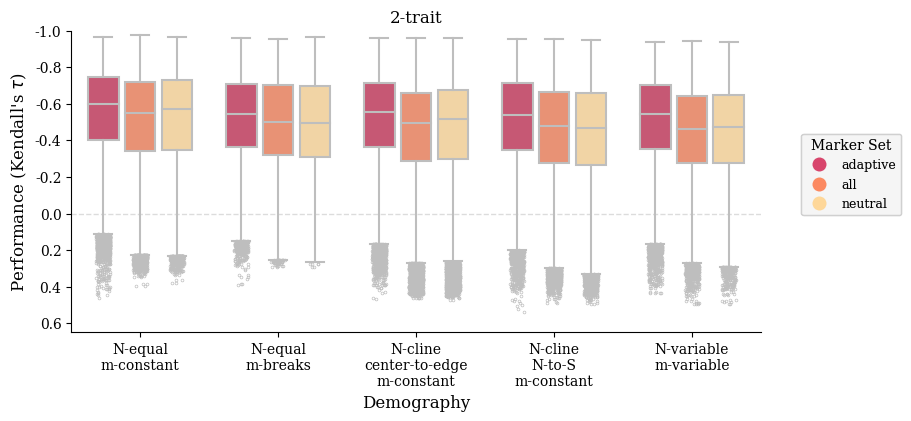

In [13]:
# 2-trait
data = mvp.subset_dataframe(all_program_data,
                            num_traits=2,
                            keep_nuisance=False)

for x, x_order in mvp.hue_order.items():
    if x in ['program', 'noncausal_env', 'marker_set']:
        continue
    
    g = sns.catplot(data=data,
                    x=x,
                    y='score',
                    hue='marker_set',
                    hue_order=mvp.hue_order['marker_set'],
                    order=x_order,
                    kind='box',
                    legend=False,
                    **mvp.boxplot_kwargs
                   )

    cleanup_fig(g, xlabel=mvp.factor_names[x], color_by='marker_set', bbox_to_anchor=(1, 0.55), fontsize=9,
                replace=('cline-', 'cline\n'), title='2-trait'
               )
    
    if x == 'demography':
        g.axes.flat[0].set_xticklabels(
            [label.get_text().replace(' m', '\nm') for label in g.axes.flat[0].get_xticklabels()]
        )

    save_pdf(op.join(figdir, f'{x}_set_by_marker_set_performance_box_2-trait.pdf'))

    plt.show()
    

### what about 2-trait bcs data

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/marker_set_by_program_performance_box_bcs.pdf


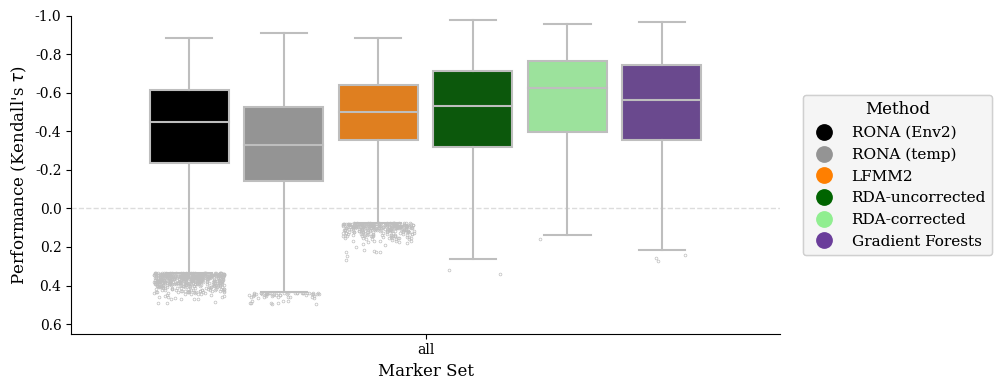

In [14]:
data = mvp.subset_dataframe(
    all_program_data,
    bcs=True
)

g = sns.catplot(data=data,
                x='marker_set',
                y='score',
                hue='program',
                order=['all'],  # bcs data only has the 'all' marker_set
                hue_order=mvp.hue_order['program'],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='Marker Set', color_by='program', bbox_to_anchor=(1, 0.55))
    
save_pdf(op.join(figdir, 'marker_set_by_program_performance_box_bcs.pdf'))

plt.show()

### look at scatter plots

In [15]:
# separate marker sets and ensure that they are in the same order and are ready for scatter plots
marker_dfs = {}
for marker_set in all_program_data.marker_set.unique():
    # resetting index is necessary for scatter2d
    marker_dfs[marker_set] = all_program_data[all_program_data.marker_set == marker_set].copy().reset_index(drop=True)

for i, marker_set_i in enumerate(all_program_data.marker_set.unique()):
    for j, marker_set_j in enumerate(all_program_data.marker_set.unique()):
        if i < j:
            for col in ['simulation_level', 'offset_level', 'simulation_garden']:
                set1 = marker_dfs[marker_set_i][col].str.replace(marker_set_i, '')
                set2 = marker_dfs[marker_set_j][col].str.replace(marker_set_j, '')
                assert all(set1 == set2)

In [16]:
def fancy_helper(set1, set2, marker_set_i, marker_set_j, subhue=None, cmap=None, pdf=None):
    g = scatter2d(x=set1.score.tolist(),
                  y=set2.score.tolist(),
                  xlim=(-1, 1),
                  ylim=(-1, 1),
                  title='',
                  cmap=cmap,
                  marginal_kws={'color' : 'gray'}
                  )

    ax = g.ax_joint

    # draw x=y line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=1, zorder=5, linewidth=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    g.ax_marg_x.set_xlim(lims)
    g.ax_marg_y.set_ylim(lims)
    
    # draw lines at x=0 and y=0
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=1, zorder=0)
    ax.axvline(0, linestyle='--', color='gainsboro', linewidth=1, zorder=0)

    ax.set_xlabel(f"$\it{marker_set_i}$ performance (Kendall's $\\tau$)")
    ax.set_ylabel(f"$\it{marker_set_j}$ performance (Kendall's $\\tau$)")

    # determine perc of set 1 <= set 2 (< means better performance)
    perc = (set1.score <= set2.score).sum() / nrow(set1)
    perc = '{:.0f}'.format(perc * 100)
    if subhue is not None:
        subtext = f'{mvp.factor_names[subhue]}\n'
    else:
        subtext = ''
    g.figure.suptitle(f'{subtext}{perc}% of $\it{marker_set_i}$ scores outperform $\it{marker_set_j}$ scores',
                      y=1.0, va='bottom')

    ax.invert_yaxis()
    ax.invert_xaxis()
    
    save_pdf(pdf)
    
    plt.show()
    
    pass


def fancy_scatter(exclude_rona=False, cmap=plt.cm.get_cmap("magma", lut=6), hue=None):
    for marker_set_i, marker_set_j in it.combinations(['adaptive', 'all', 'neutral'], 2):

        iset1 = marker_dfs[marker_set_i]
        jset2 = marker_dfs[marker_set_j]
        
        # exclude nan scores (mostly RONA oligogenic where no adaptive markers had linear relationships with envs)
        iset1 = iset1[iset1.score.notnull() & jset2.score.notnull()]  # scores are in same order so this works
        jset2 = jset2[iset1.score.notnull() & jset2.score.notnull()]

        if exclude_rona is True:
            ronatext = 'out'
            iset1 = iset1[~iset1.program.str.contains('RONA')]
            jset2 = jset2[~jset2.program.str.contains('RONA')]
        else:
            ronatext = ''

        pdf_start = f'{figdir}/{marker_set_i}_{marker_set_j}_2dscatter_with{ronatext}-RONA'
        if hue is not None:
            for element in mvp.hue_order[hue]:

                set1 = iset1[iset1[hue] == element]
                set2 = jset2[jset2[hue] == element]

                fancy_helper(set1, set2, marker_set_i, marker_set_j, element, cmap=cmap,
                             pdf=f'{pdf_start}_{element}.pdf')
        else:
            fancy_helper(iset1, jset2, marker_set_i, marker_set_j, cmap=cmap,
                         pdf=f'{pdf_start}.pdf')

        pass

In [17]:
for marker_set_i, marker_set_j in it.combinations(['adaptive', 'all', 'neutral'], 2):
    set1 = marker_dfs[marker_set_i]
    set2 = marker_dfs[marker_set_j]
    
    perc = (set1.score <= set2.score).sum() / nrow(set1)
    
    print(perc, 'of ', marker_set_i, 'scores are <= than scores from', marker_set_j)
    

0.6762842911877395 of  adaptive scores are <= than scores from all
0.671255938697318 of  adaptive scores are <= than scores from neutral
0.7365088122605364 of  all scores are <= than scores from neutral


Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA.pdf


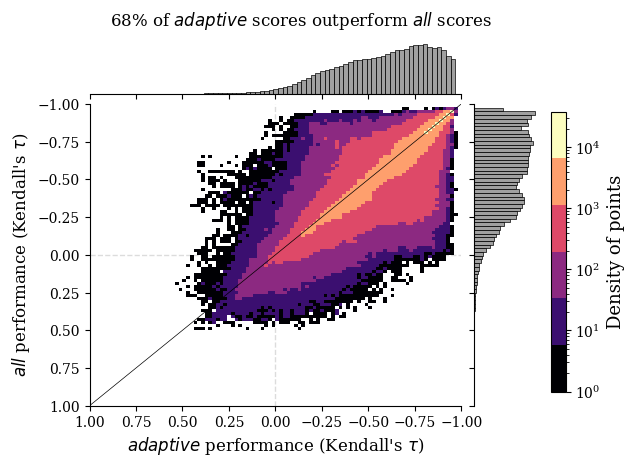

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA.pdf


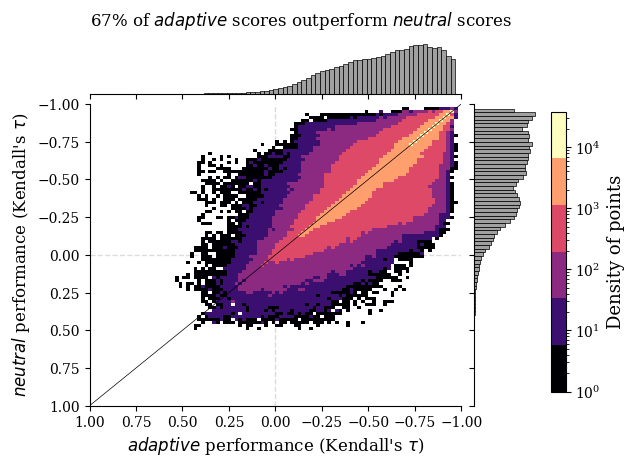

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA.pdf


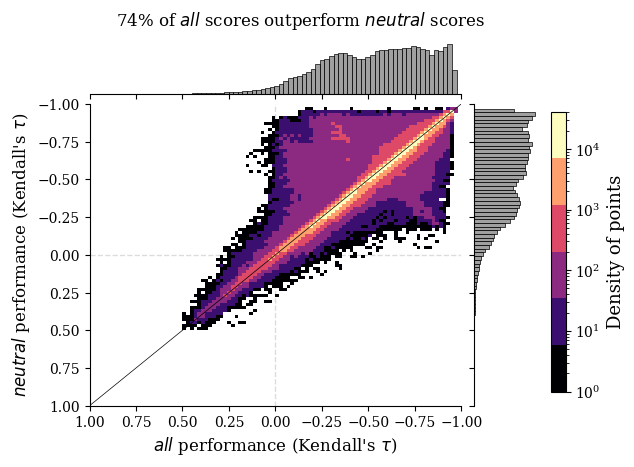

In [18]:
fancy_scatter()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_without-RONA.pdf


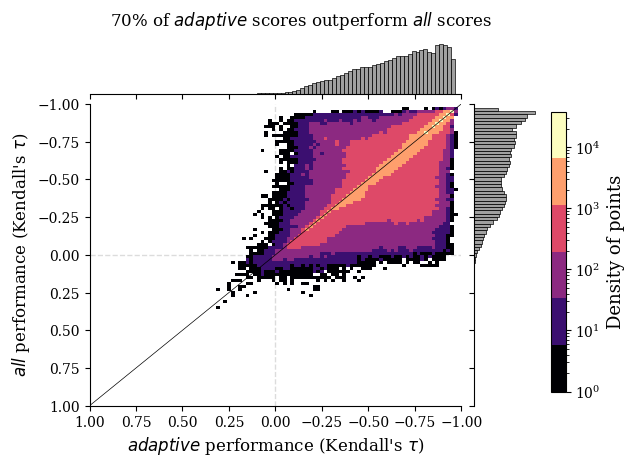

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_without-RONA.pdf


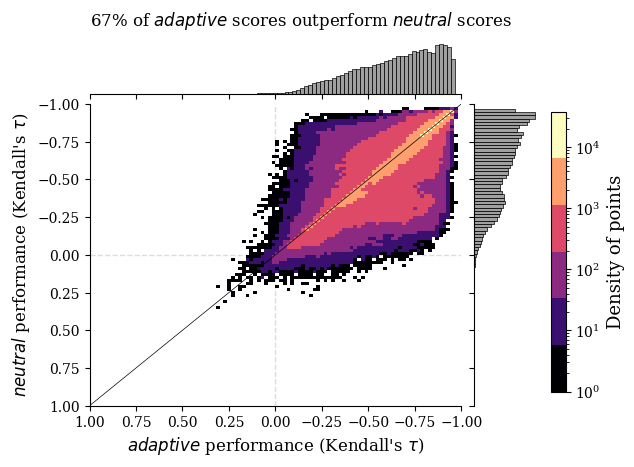

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_without-RONA.pdf


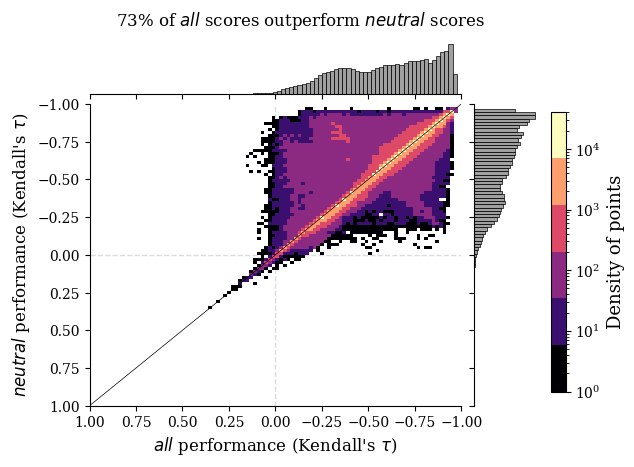

In [19]:
fancy_scatter(exclude_rona=True)

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_RONA-sal_opt.pdf


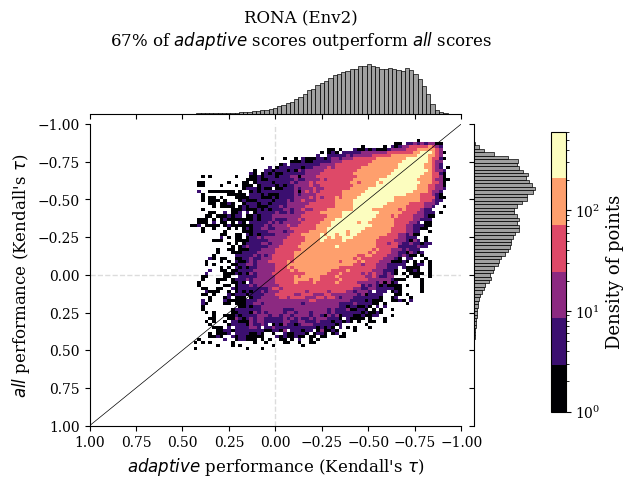

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_RONA-temp_opt.pdf


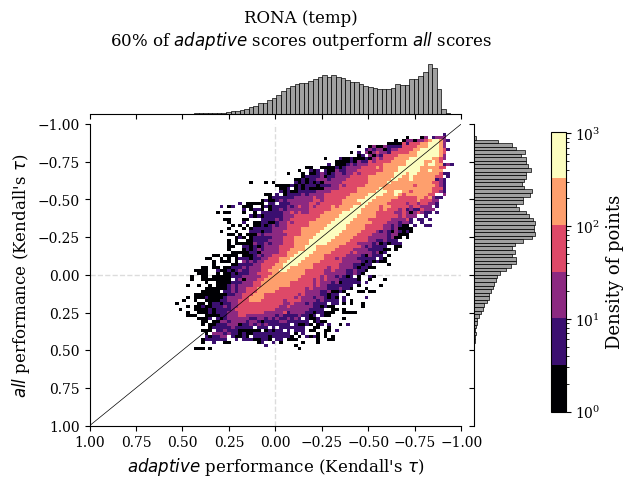

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_lfmm2.pdf


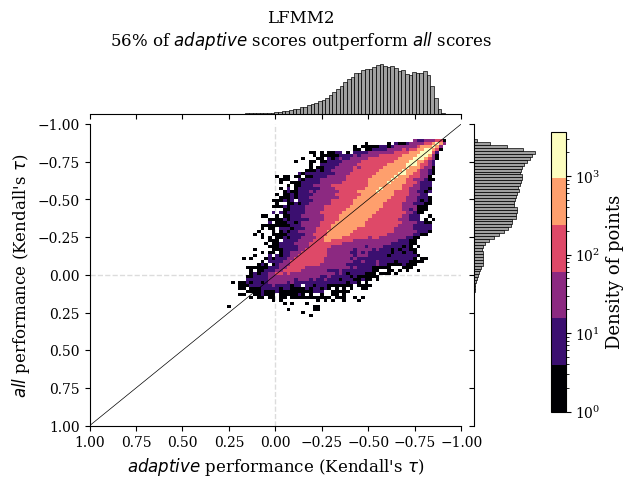

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_rda-nocorr.pdf


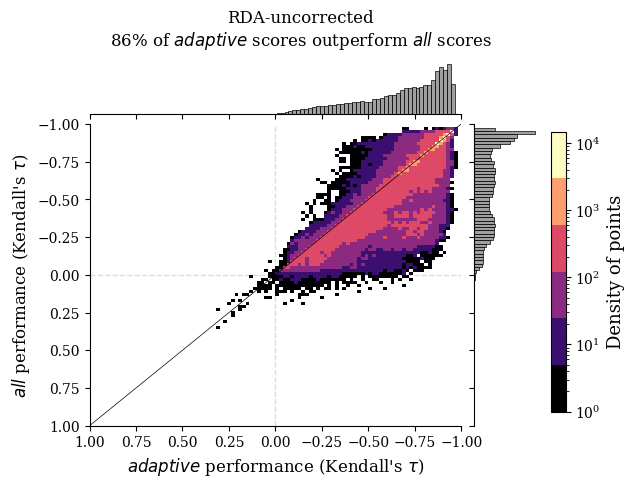

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_rda-structcorr.pdf


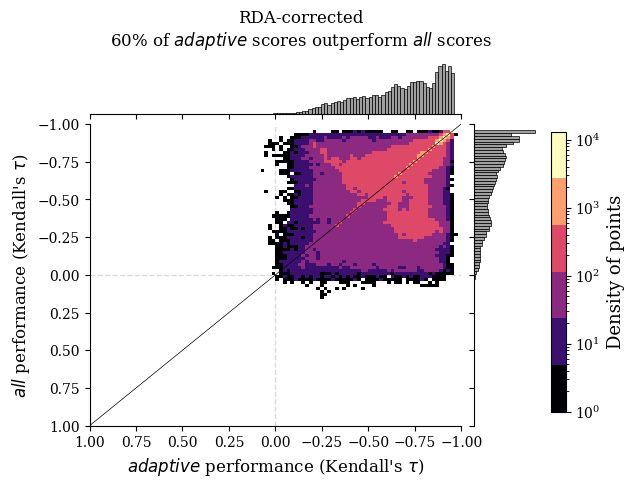

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_GF.pdf


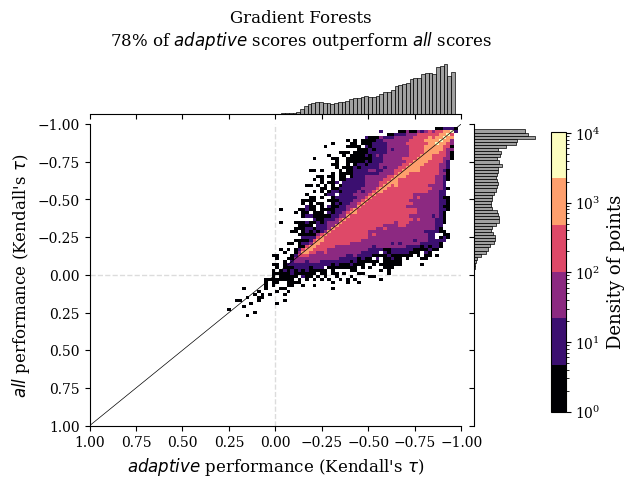

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_RONA-sal_opt.pdf


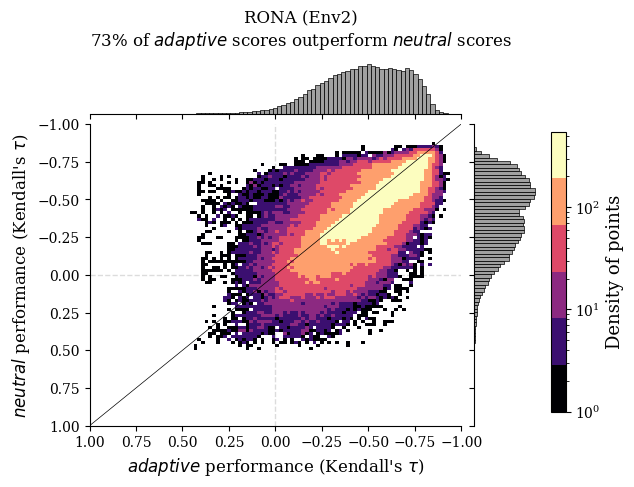

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_RONA-temp_opt.pdf


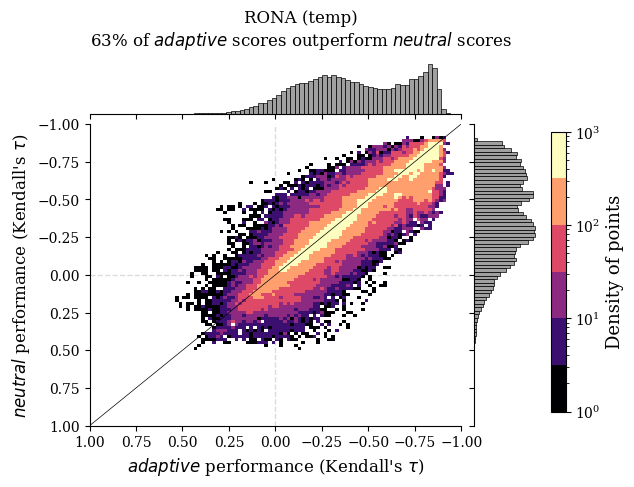

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_lfmm2.pdf


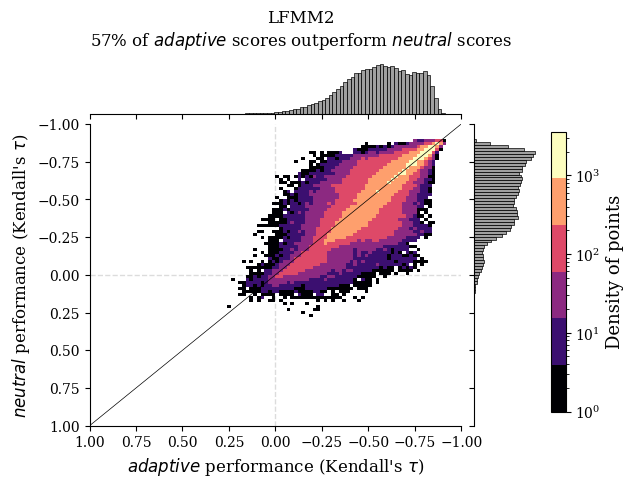

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_rda-nocorr.pdf


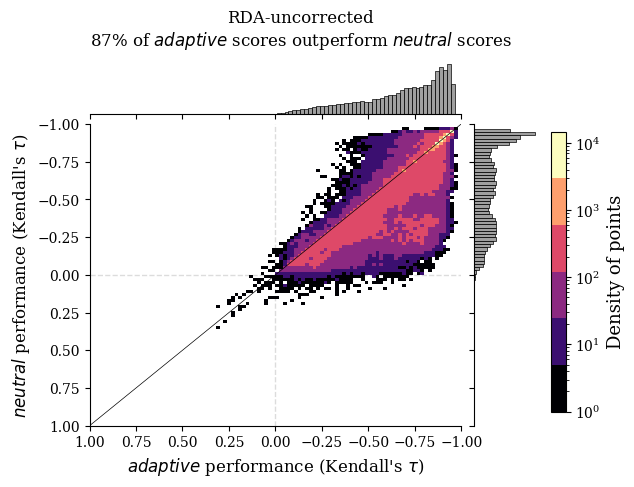

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_rda-structcorr.pdf


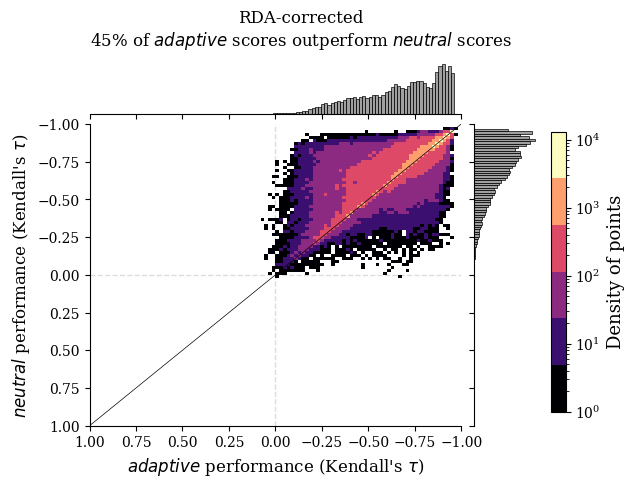

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_GF.pdf


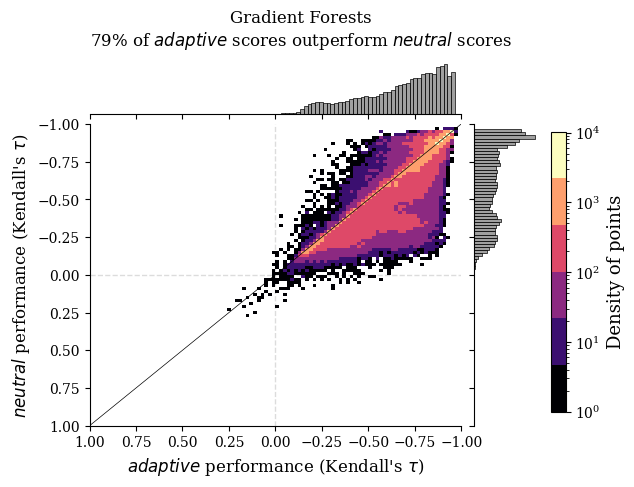

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_RONA-sal_opt.pdf


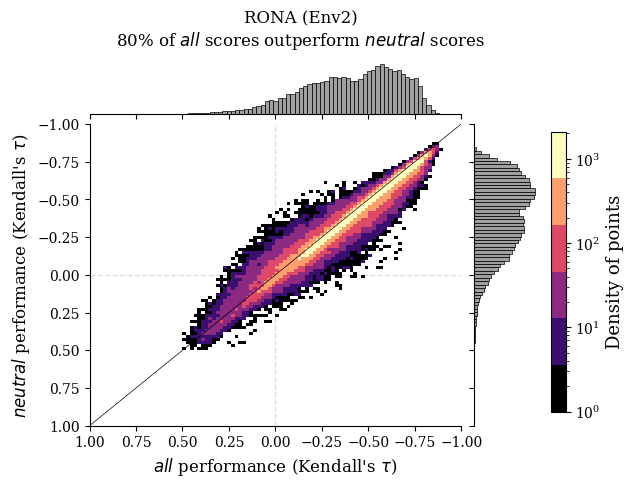

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_RONA-temp_opt.pdf


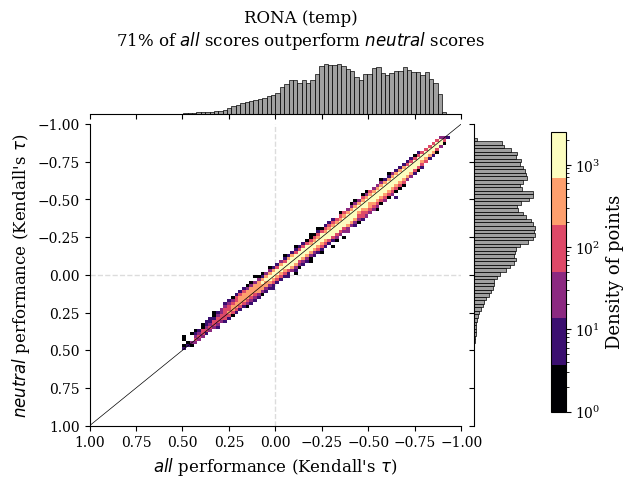

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_lfmm2.pdf


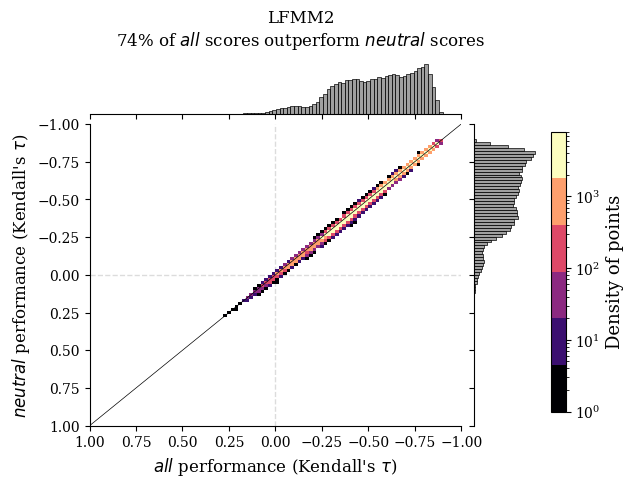

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_rda-nocorr.pdf


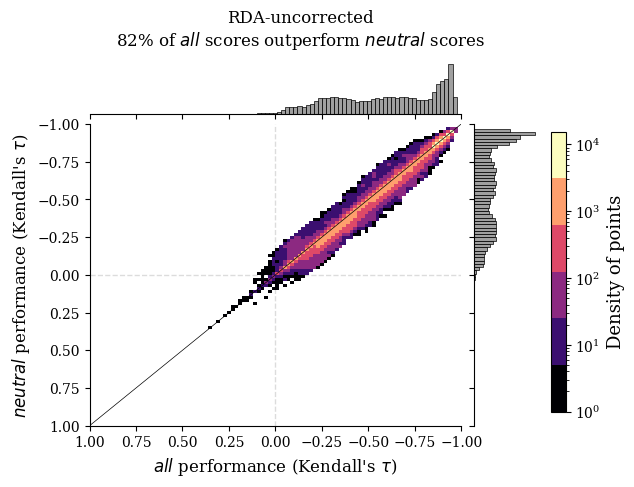

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_rda-structcorr.pdf


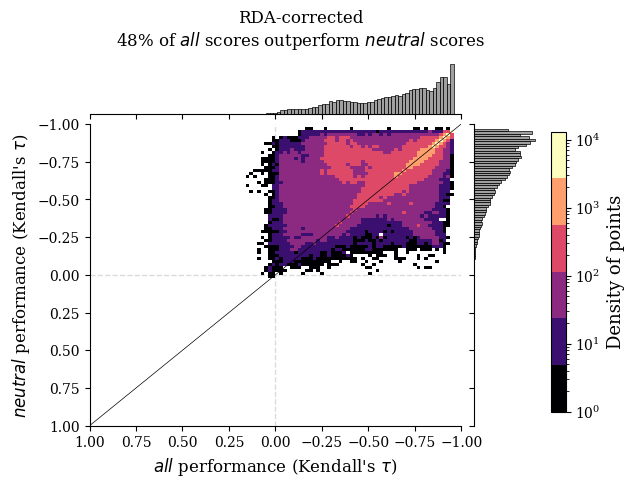

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_GF.pdf


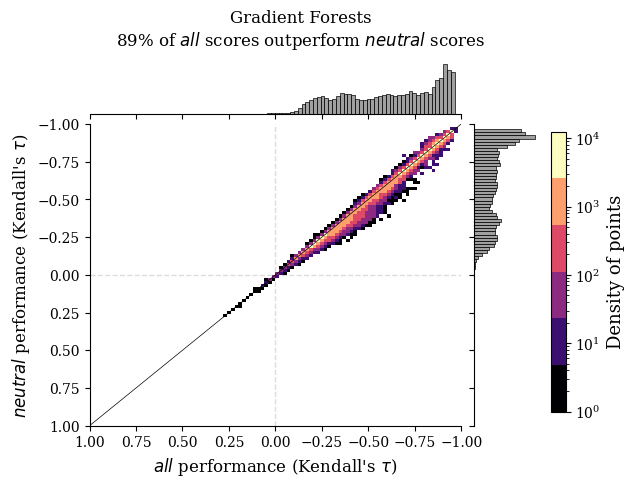

In [20]:
fancy_scatter(hue='program')

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_SS-Clines.pdf


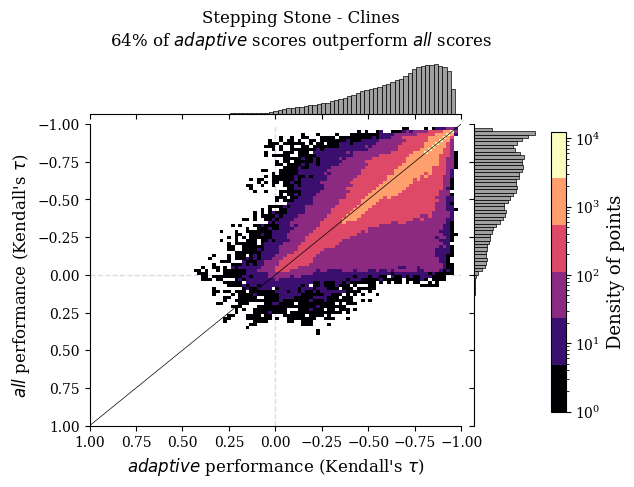

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_SS-Mtn.pdf


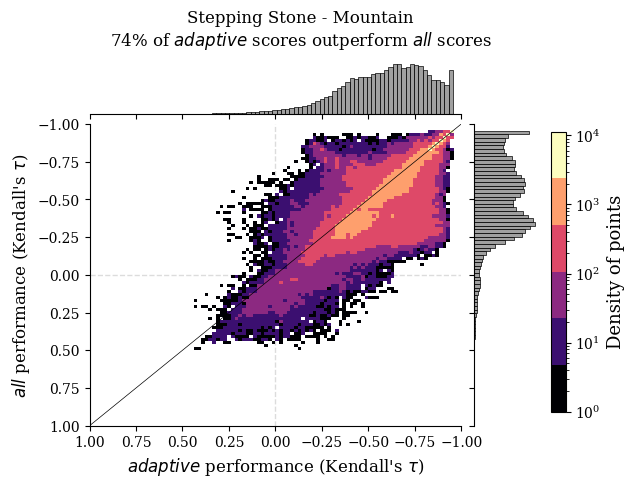

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_with-RONA_Est-Clines.pdf


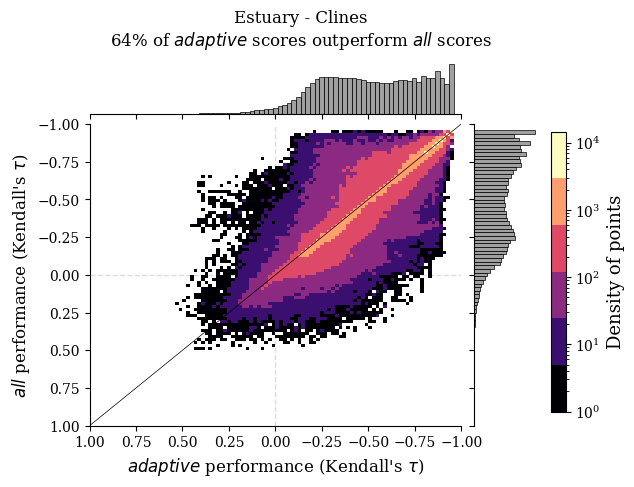

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_SS-Clines.pdf


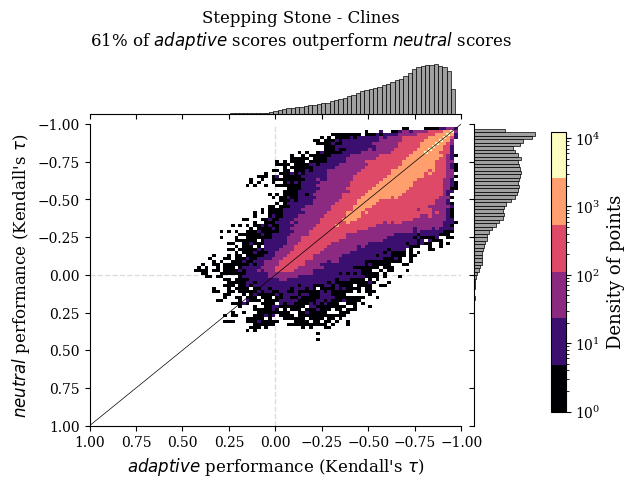

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_SS-Mtn.pdf


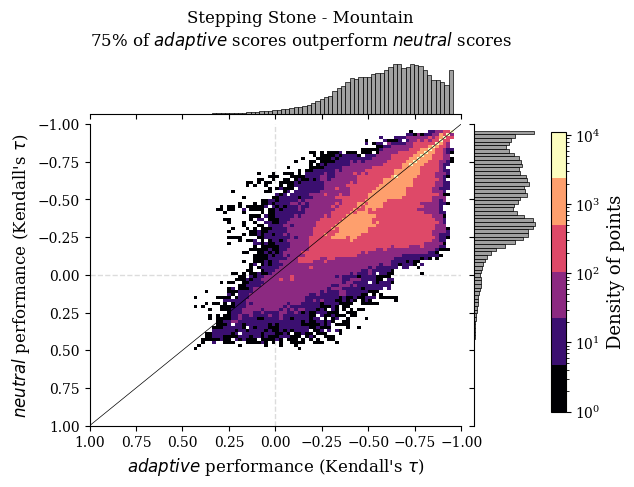

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_with-RONA_Est-Clines.pdf


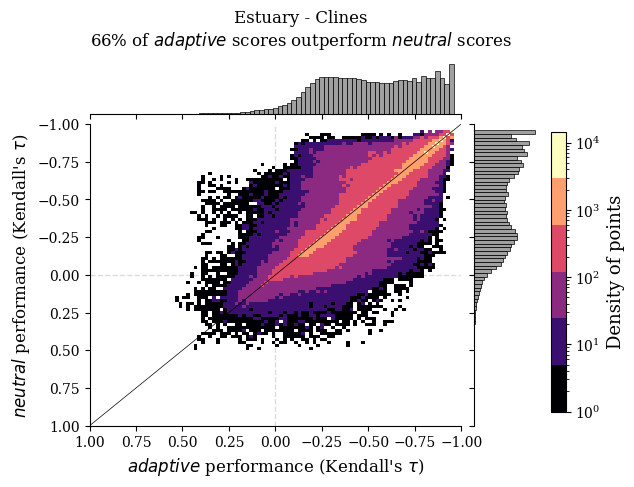

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_SS-Clines.pdf


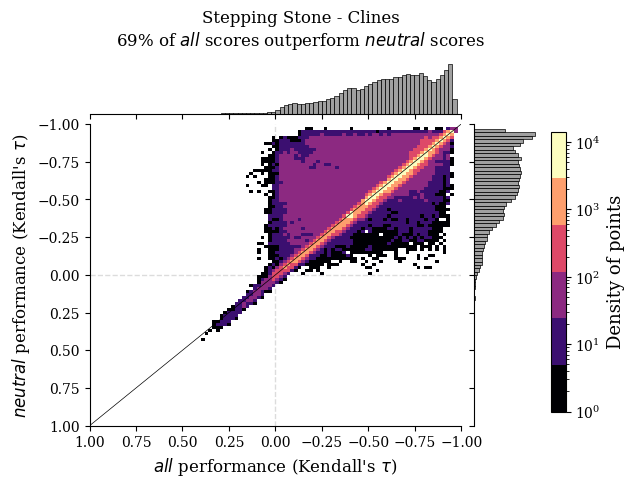

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_SS-Mtn.pdf


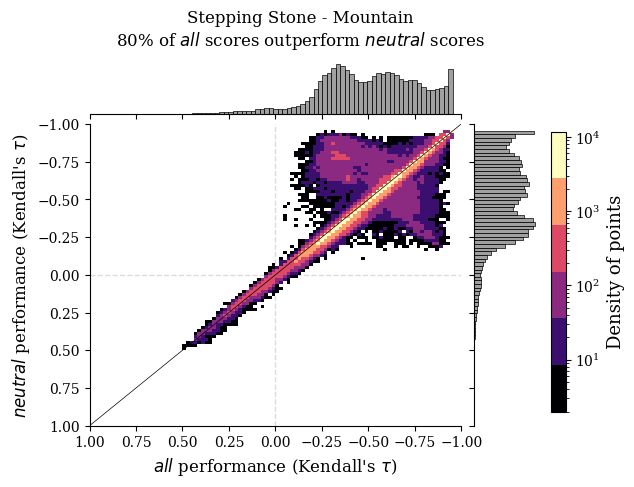

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_with-RONA_Est-Clines.pdf


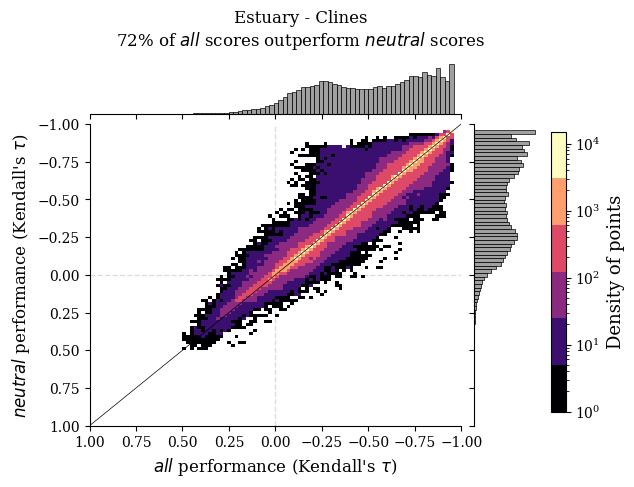

In [21]:
fancy_scatter(hue='landscape')

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_without-RONA_SS-Clines.pdf


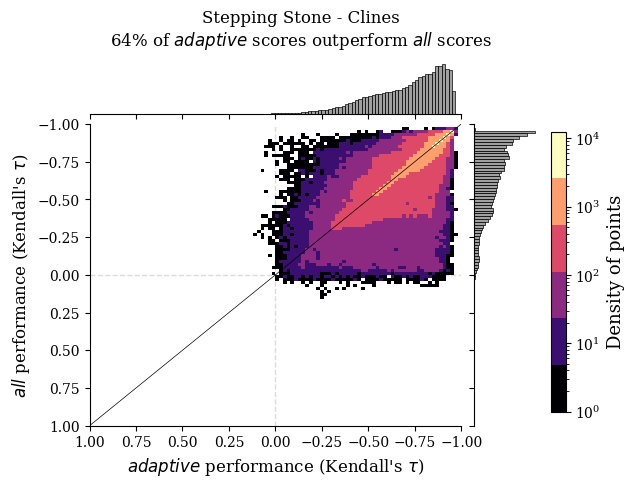

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_without-RONA_SS-Mtn.pdf


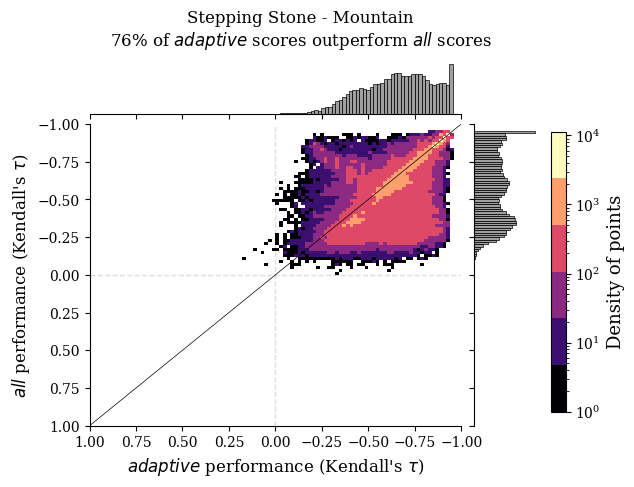

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_without-RONA_Est-Clines.pdf


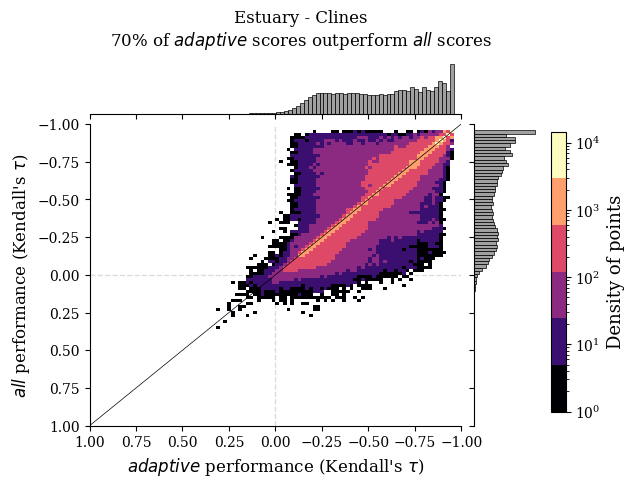

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_without-RONA_SS-Clines.pdf


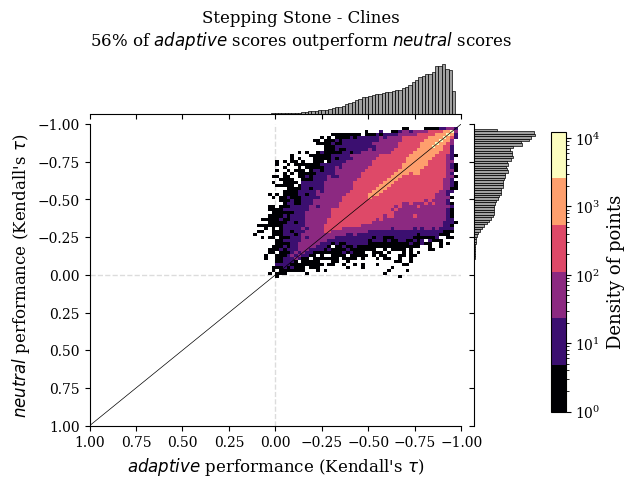

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_without-RONA_SS-Mtn.pdf


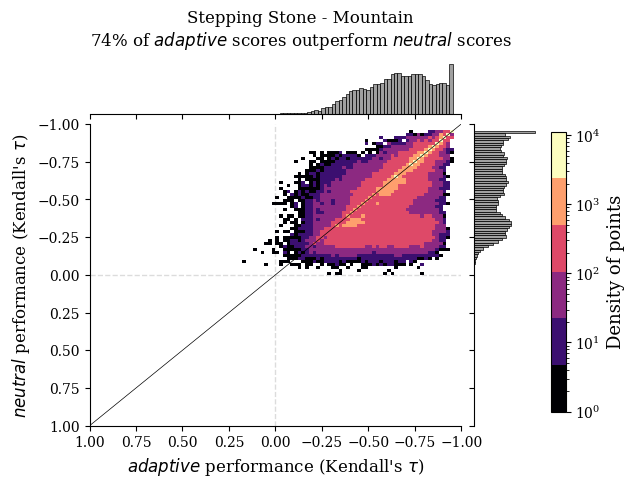

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_without-RONA_Est-Clines.pdf


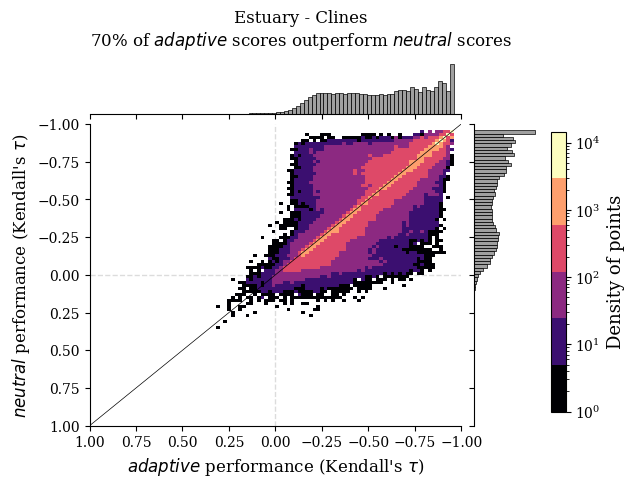

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_without-RONA_SS-Clines.pdf


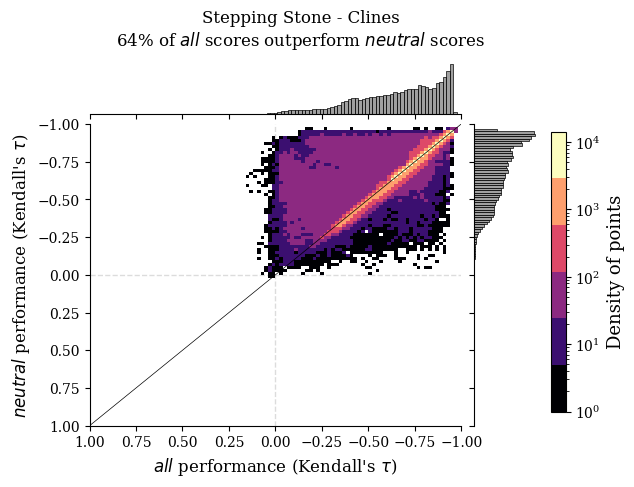

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_without-RONA_SS-Mtn.pdf


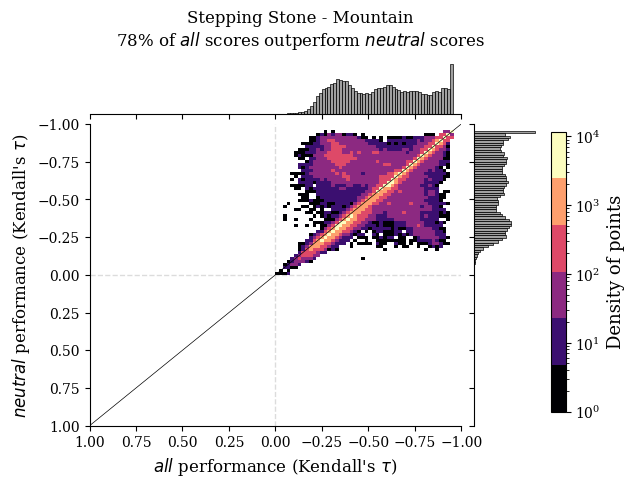

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_without-RONA_Est-Clines.pdf


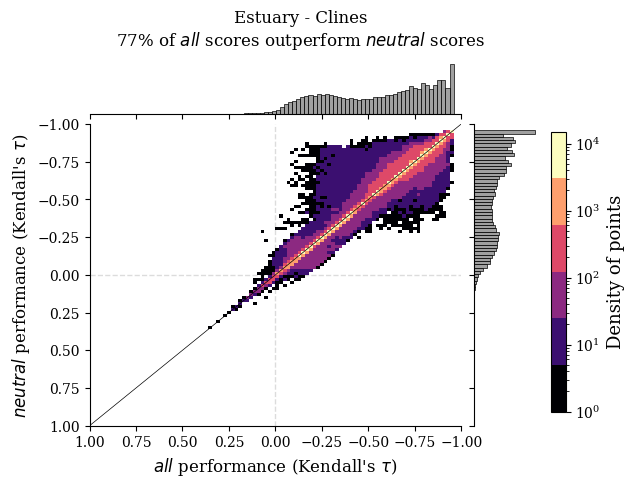

In [22]:
fancy_scatter(hue='landscape', exclude_rona=True)

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_without-RONA_equal-S.pdf


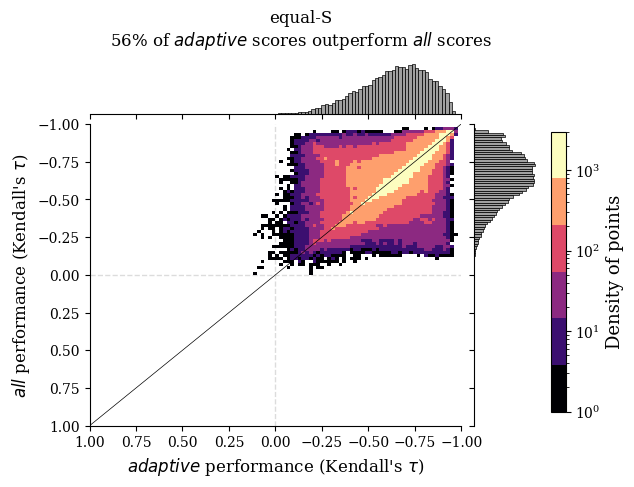

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_all_2dscatter_without-RONA_unequal-S.pdf


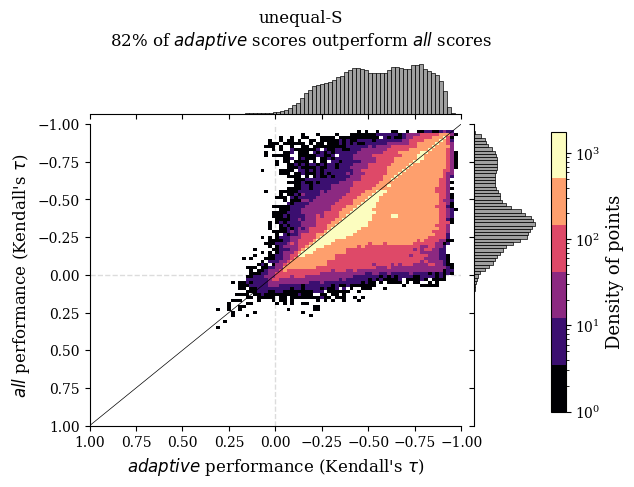

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_without-RONA_equal-S.pdf


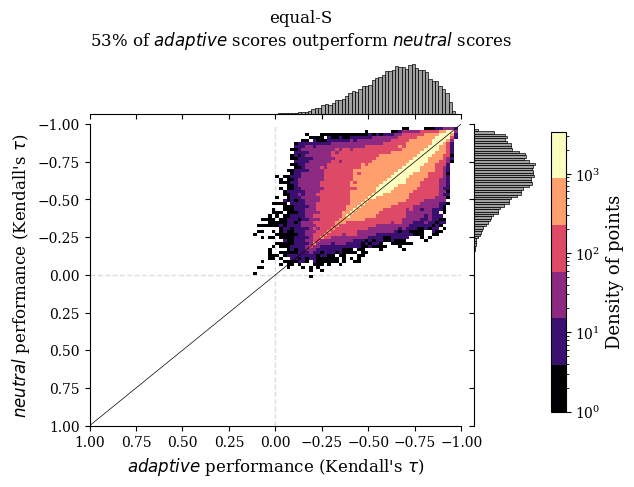

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/adaptive_neutral_2dscatter_without-RONA_unequal-S.pdf


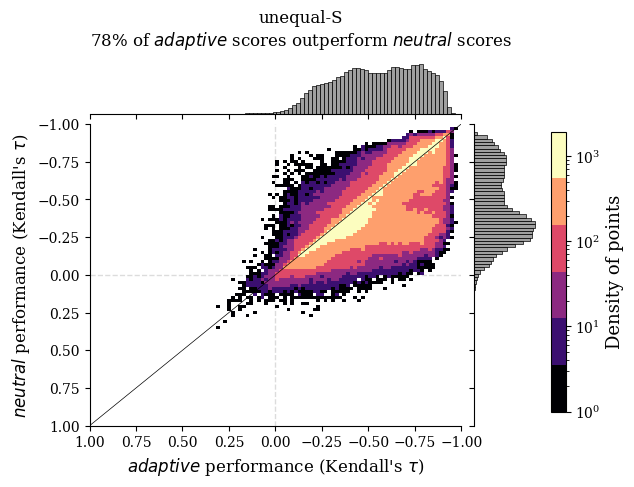

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_without-RONA_equal-S.pdf


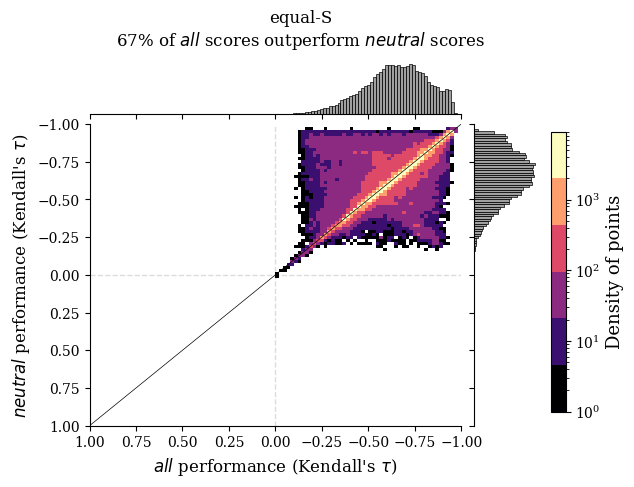

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/all_neutral_2dscatter_without-RONA_unequal-S.pdf


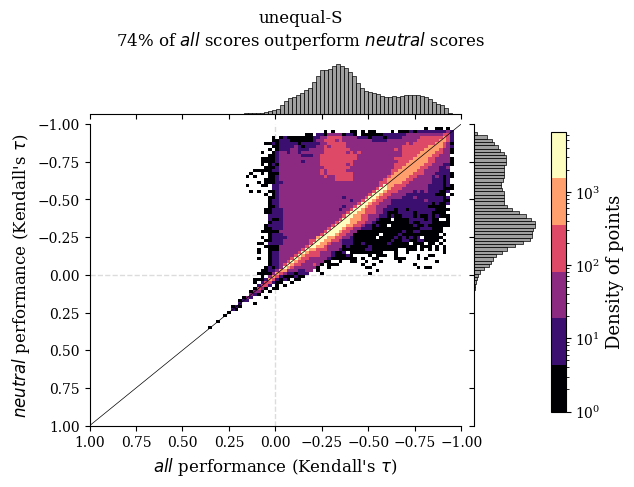

In [23]:
fancy_scatter(hue='slevel', exclude_rona=True)

# compare gain by marker set

In [63]:
def get_index(df, marker_set):
    """Get a unique name for comparing later."""
    index = df[
        ['offset_level', 'program', 'garden', 'seed']
    ].astype(str)\
        .agg('_'.join, axis=1)\
        .str.replace(' ', '-')\
        .str.replace(f'_{marker_set}_', '_')  # remove marker set name 
    
    assert luni(index) == nrow(df)
    
    return index


def compare_diffs(exclude_rona=False, hue=None, gain=True):
    """Compare differences in performance between pairwise marker sets.

    Parameters
    ----------
    exclude_rona : bool
    hue : str
    gain : bool
        whether to compare scores when marker_set_i is better (True) or vice versa (False)
    """        

    diffs = wrap_defaultdict(dict, 3)
    for marker_set_i, marker_set_j in it.combinations(['adaptive', 'all', 'neutral'], 2):

        print(f'\n{marker_set_i}, {marker_set_j}')

        iset1 = marker_dfs[marker_set_i].copy()
        jset2 = marker_dfs[marker_set_j].copy()

        # exclude nan scores (mostly RONA oligogenic where no adaptive markers had linear relationships with envs)
        good_scores = iset1.score.notnull() & jset2.score.notnull()
        iset1 = iset1[good_scores]  # scores are in same order so this works
        jset2 = jset2[good_scores]

        if exclude_rona is True:
            ronatext = 'out'
            iset1 = iset1[~iset1.program.str.contains('RONA')]
            jset2 = jset2[~jset2.program.str.contains('RONA')]
        else:
            ronatext = ''

        pdf_start = f'{figdir}/{marker_set_i}_{marker_set_j}_2dscatter_with{ronatext}-RONA'
        if hue is not None:
            for element in mvp.hue_order[hue]:
                print(f'\t{element}')

                aset1 = iset1[iset1[hue] == element]
                aset2 = jset2[jset2[hue] == element]

                if gain is True:
                    # both are aset1.score < aset2.score to include only comparisons when adaptive markers are better
                    set1 = aset1[aset1.score < aset2.score]
                    set2 = aset2[aset1.score < aset2.score]
                elif gain is False:
                    set1 = aset1[aset1.score > aset2.score]
                    set2 = aset2[aset1.score > aset2.score]
                else:
                    set1 = aset1
                    set2 = aset2

#                 # sanity check (always passed, just takes quite a bit of time)
                index = get_index(set1, marker_set_i)
                index2 = get_index(set2, marker_set_j)
                assert all(index == index2)

                # we want 1 - 2 because this will give correct sign if improved (neg) relative to 1
                diff = set1.score - set2.score

                perc_diff = (diff / set1.score) * 100
                diff.index = index.tolist()
                perc_diff.index = index.tolist()

                perc_diff = perc_diff[perc_diff != -math.inf]

                print(f'median diff = ', diff.median())
                print('perc diff = ', perc_diff.median())
                
                diffs[f'{marker_set_i}-{marker_set_j}']['perc_diff'][f'{hue}_{element}'] = perc_diff
                diffs[f'{marker_set_i}-{marker_set_j}']['diff'][f'{hue}_{element}'] = diff

    #             histo_box(diff, histplot_kws=dict(edgecolor='white'), boxplot_kws=dict(linewidth=0.80))

        else:
            if gain is True:
                # both are iset1.score < jset2.score to include only comparisons when adaptive markers are better
                set1 = iset1[iset1.score < jset2.score]
                set2 = jset2[iset1.score < jset2.score]
            elif gain is False:
                set1 = iset1[iset1.score > jset2.score]
                set2 = jset2[iset1.score > jset2.score]
            else:
                set1 = iset1
                set2 = jset2
            
#             # sanity check (always passed, just takes quite a bit of time)
            index = get_index(set1, marker_set_i)
            index2 = get_index(set2, marker_set_j)
            assert all(index == index2)

            if gain is True or gain is None:
                diff = set1.score - set2.score
                perc_diff = (diff / set1.score) * 100
            elif gain is False:
                diff = set2.score - set1.score
                perc_diff = (diff / set2.score) * 100
                
            diff.index = index
            perc_diff.index = index

            perc_diff = perc_diff[perc_diff != -math.inf]
            
            diffs[f'{marker_set_i}-{marker_set_j}']['perc_diff'][hue] = perc_diff
            diffs[f'{marker_set_i}-{marker_set_j}']['diff'][hue] = diff
            
            print(f'median diff = ', diff.median())
            print('perc diff = ', perc_diff.median())

    #         boxplot_kws = defaultdict(dict); boxplot_kws.update({'linewidth' : 0.80})
    #         histo_box(perc_diff, histplot_kws=dict(edgecolor='white'), boxplot_kws=boxplot_kws,
    #                   title=f'{marker_set_i} vs. {marker_set_j}')

    return diffs

In [25]:
for gain in [True, False, None]:
    print(ColorText(f'\n{gain = }').bold().custom('blue'))
    
    diffs = compare_diffs(gain=gain)


gain = True

adaptive, all
median diff =  -0.08404040404040392
perc diff =  16.00405182103652

adaptive, neutral
median diff =  -0.0820202020202021
perc diff =  15.669109871415658

all, neutral
median diff =  -0.016969696969696912
perc diff =  3.4627983153954127

gain = False

adaptive, all
median diff =  -0.05414141414141416
perc diff =  9.501187648456067

adaptive, neutral
median diff =  -0.05011619912973597
perc diff =  8.768656716417917

all, neutral
median diff =  -0.015353535353535341
perc diff =  2.9190362879987584

gain = None

adaptive, all
median diff =  -0.016161616161616044
perc diff =  2.8414834263910587

adaptive, neutral
median diff =  -0.012929292929292902
perc diff =  2.346182892985072

all, neutral
median diff =  -0.004040404040404042
perc diff =  0.8084074373484287


In [26]:
# why is perc diff gain=None < 1 ???

In [27]:
# how do adaptive gains compare to marker_set_j gains?
# numbers are hard-coded from previous cell output
for x, y in [(9.5, 16), (8.77, 15.66), (2.92, 3.46)]:
    print(x / y)

0.59375
0.5600255427841634
0.8439306358381503


In [28]:
for gain in [True, False, None]:
    print(ColorText(f'\n{gain = }').bold().custom('blue'))
    
    diffs = compare_diffs(exclude_rona=True, gain=gain)


gain = True

adaptive, all
median diff =  -0.08164090503392463
perc diff =  15.0057273768614

adaptive, neutral
median diff =  -0.07353535353535354
perc diff =  13.339295718984005

all, neutral
median diff =  -0.01252525252525255
perc diff =  2.6296292434331323

gain = False

adaptive, all
median diff =  -0.05252525252525253
perc diff =  7.895505435716081

adaptive, neutral
median diff =  -0.047272727272727244
perc diff =  7.16612377850163

all, neutral
median diff =  -0.018181818181818188
perc diff =  2.9578351164254433

gain = None

adaptive, all
median diff =  -0.010527939132608008
perc diff =  1.7890772128060375

adaptive, neutral
median diff =  -0.0036363636363636598
perc diff =  0.5695977296299914

all, neutral
median diff =  -0.0008080808080808133
perc diff =  0.11555684193149875


In [29]:
# how do adaptive gains compare to marker_set_j gains?
# numbers are hard-coded from previous cell output
for x, y in [(2.95, 2.62), (7.90, 13.33), (7.89, 15)]:
    print(x / y)

1.1259541984732824
0.5926481620405102
0.526


In [81]:
diffs = compare_diffs(gain=None)


adaptive, all
median diff =  -0.016161616161616044
perc diff =  2.8414834263910587

adaptive, neutral
median diff =  -0.012929292929292902
perc diff =  2.346182892985072

all, neutral
median diff =  -0.004040404040404042
perc diff =  0.8084074373484287


In [82]:
diffs_no_rona = compare_diffs(exclude_rona=True, gain=None)


adaptive, all
median diff =  -0.010527939132608008
perc diff =  1.7890772128060375

adaptive, neutral
median diff =  -0.0036363636363636598
perc diff =  0.5695977296299914

all, neutral
median diff =  -0.0008080808080808133
perc diff =  0.11555684193149875


In [83]:
diffs_by_program = compare_diffs(hue='program', gain=None)


adaptive, all
	RONA-sal_opt
median diff =  -0.050562368150100845
perc diff =  10.22039547859153
	RONA-temp_opt
median diff =  -0.017373737373737375
perc diff =  3.4123222748815247
	lfmm2
median diff =  -0.005656565656565582
perc diff =  0.8387698042870382
	rda-nocorr
median diff =  -0.03820285756284427
perc diff =  6.672192991706319
	rda-structcorr
median diff =  0.0
perc diff =  -0.0
	GF
median diff =  -0.018989898989899
perc diff =  3.249699298752351

adaptive, neutral
	RONA-sal_opt
median diff =  -0.07555555555555549
perc diff =  15.380200452370254
	RONA-temp_opt
median diff =  -0.024242424242424288
perc diff =  5.617977528089896
	lfmm2
median diff =  -0.008080808080808133
perc diff =  1.2764017921216353
	rda-nocorr
median diff =  -0.046727832959236104
perc diff =  8.24518176332436
	rda-structcorr
median diff =  0.004444444444444473
perc diff =  -0.648411513483231
	GF
median diff =  -0.022741409744598484
perc diff =  3.878241262683203

all, neutral
	RONA-sal_opt
median diff =  -0.0

In [84]:
for name, _diffs in zip(['diffs', 'diffs_no_rona', 'diffs_by_program'], [diffs, diffs_no_rona, diffs_by_program]):
    pkl = f'{figdir}/{name}.pkl'
    
    pkldump(_diffs, pkl)
    print(pkl)

/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/diffs.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/diffs_no_rona.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/03_Q3_effect_of_marker_set/figs/diffs_by_program.pkl


In [37]:
formatclock(dt.now() - t0)

'0-00:12:53'